# HOUSING MARKET INDEX

In [91]:
import pandas as pd
import sqlite3

# Define file paths
file_paths = {
    "B25003": "housing_data/B25003.xlsx",     # Owner vs renter
    "B25002": "housing_data/B25002.xlsx",     # Occupancy (vacancy rate)
    "B25077": "housing_data/B25077.xlsx",     # Median Home Value
    "B19013": "housing_data/B19013.xlsx",     # Median Household Income
    "B25070": "housing_data/B25070.xlsx",     # Gross Rent as % Income
    "C40":     "housing_data/C-40.xlsx",      # New housing units
    "PEPANNRES": "housing_data/PEPANNRES.xlsx",  # Population
    "B25091": "housing_data/B25091.xlsx",     # ✅ Owner Cost Burden (optional)
    "B25036": "housing_data/B25036.xlsx",      # ✅ Year Structure Built (optional)
    "PopulationChange": "housing_data/ChangeInPopulation.xlsx"

}

# Load and normalize Geography column in each file


dfs = {}
for key, path in file_paths.items():
    df = pd.read_excel(path, sheet_name=0)
    df.columns = df.columns.str.strip()  # Clean whitespace in column names

    if "Geography" in df.columns:
        df["Geography"] = df["Geography"].str.strip()
        df["Geography"] = df["Geography"].str.replace(" Metro Area", "", regex=False)
        df["Geography"] = df["Geography"].str.replace(" MSA", "", regex=False)
        df["Geography"] = df["Geography"].str.replace("–", "-", regex=False)
        df["Geography"] = df["Geography"].str.replace("—", "-", regex=False)
        df["Geography"] = df["Geography"].str.replace(u"\xa0", " ", regex=False)  # non-breaking space
        df["Geography"] = df["Geography"].str.replace("-", "-", regex=False)

        # ✅ Extract only the first place name (before comma or dash)
        df["Geography"] = df["Geography"].str.split(",|-").str[0].str.strip()

    dfs[key] = df




# Create SQLite in-memory database
conn = sqlite3.connect(":memory:")

# Load each DataFrame into SQLite
for name, df in dfs.items():
    df.to_sql(name, conn, index=False, if_exists='replace')



# SQL query for joined dataset
sql_query = """
SELECT 
    B25003.Geography AS Metro_Area,
    B25003.[Total] AS Total_Housing_Units,
    B25003.[Owner occupied],
    B25003.[Renter occupied],
    B25002.[Vacant],
    B25077.[Median value (dollars)] AS Median_Home_Value,
    B19013.MedianHouseholdIncome,
    B25070.[50.0 percent or more] AS High_Rent_Burden,
    C40.[Total] AS New_Housing_Units,
    PEPANNRES.Population,
    PopulationChange.[Percent Change in Population (2020-2024)],
    B25091.owner_cost_burden,
    B25036.[Built 2010 or later] AS Recent_Units_Share
FROM B25003
LEFT JOIN B25002 ON B25003.Geography = B25002.Geography
LEFT JOIN B25077 ON B25003.Geography = B25077.Geography
LEFT JOIN B19013 ON B25003.Geography = B19013.Geography
LEFT JOIN B25070 ON B25003.Geography = B25070.Geography
LEFT JOIN C40 ON B25003.Geography = C40.Geography
LEFT JOIN PEPANNRES ON B25003.Geography = PEPANNRES.Geography
LEFT JOIN B25091 ON B25003.Geography = B25091.Geography
LEFT JOIN B25036 ON B25003.Geography = B25036.Geography
LEFT JOIN PopulationChange ON B25003.Geography = PopulationChange.Geography
GROUP BY PopulationChange.Geography
ORDER BY PEPANNRES.Population DESC
LIMIT 101



"""

# Execute and load the result into a DataFrame
housing_index_df = pd.read_sql_query(sql_query, conn)

# Preview or export
# housing_index_df.to_csv("Housing_Market_Index_Base.csv", index=False)

# Close SQLite connection
conn.close()

housing_index_df

,Metro_Area,Total_Housing_Units,Owner occupied,Renter occupied,Vacant,Median_Home_Value,MedianHouseholdIncome,High_Rent_Burden,New_Housing_Units,Population,Percent Change in Population (2020-2024),Owner_Cost_Burden,Recent_Units_Share
0,New York,"7,490,498","3,825,885","3,664,613","593,023",610200,95220,"983,573",56661.0,19052774,-0.007054,1220190,540955
1,Los Angeles,"4,542,998","2,189,902","2,353,096","285,894",867200,91960,"686,139",31151.0,12828837,-0.020709,747559,318295
2,Chicago,"3,671,659","2,420,840","1,250,819","240,243",316500,87071,"285,897",18511.0,9461105,-0.004315,597290,246398
3,Dallas,"2,959,385","1,769,613","1,189,772","212,902",373900,86860,"295,171",78705.0,6366542,0.092524,436350,724661
4,Philadelphia,"2,484,152","1,668,735","815,417","159,676",356700,86867,"212,866",36307.0,5965343,0.013670,386556,188296
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,Pensacola,"204,344","148,104","56,240","28,687",308600,78315,"12,679",4051.0,455139,0.056918,32809,39853
97,Visalia,"145,442","86,036","59,406","9,803",339800,73097,"15,209",1510.0,442179,0.022043,23492,16052
98,Fayetteville,"150,658","88,351","62,307","15,242",216900,61220,"14,154",2307.0,440121,0.018102,20811,23193
99,York,"183,864","138,048","45,816","7,235",257600,81362,"8,431",1316.0,434972,0.032429,28212,12884


In [92]:
housing_index_df = housing_index_df.dropna()

housing_index_df

,Metro_Area,Total_Housing_Units,Owner occupied,Renter occupied,Vacant,Median_Home_Value,MedianHouseholdIncome,High_Rent_Burden,New_Housing_Units,Population,Percent Change in Population (2020-2024),Owner_Cost_Burden,Recent_Units_Share
0,New York,"7,490,498","3,825,885","3,664,613","593,023",610200,95220,"983,573",56661.0,19052774,-0.007054,1220190,540955
1,Los Angeles,"4,542,998","2,189,902","2,353,096","285,894",867200,91960,"686,139",31151.0,12828837,-0.020709,747559,318295
2,Chicago,"3,671,659","2,420,840","1,250,819","240,243",316500,87071,"285,897",18511.0,9461105,-0.004315,597290,246398
3,Dallas,"2,959,385","1,769,613","1,189,772","212,902",373900,86860,"295,171",78705.0,6366542,0.092524,436350,724661
4,Philadelphia,"2,484,152","1,668,735","815,417","159,676",356700,86867,"212,866",36307.0,5965343,0.013670,386556,188296
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,Pensacola,"204,344","148,104","56,240","28,687",308600,78315,"12,679",4051.0,455139,0.056918,32809,39853
97,Visalia,"145,442","86,036","59,406","9,803",339800,73097,"15,209",1510.0,442179,0.022043,23492,16052
98,Fayetteville,"150,658","88,351","62,307","15,242",216900,61220,"14,154",2307.0,440121,0.018102,20811,23193
99,York,"183,864","138,048","45,816","7,235",257600,81362,"8,431",1316.0,434972,0.032429,28212,12884


### Feature Engineering
| **Feature**           | **Formula**                                                                       | **Description**                          |
| --------------------- | --------------------------------------------------------------------------------- | ---------------------------------------- |
| `Affordability_Ratio` | `Median_Home_Value / MedianHouseholdIncome`                                       | High = less affordable                   |
| `Vacancy_Rate`        | `Vacant / Total_Housing_Units`                                                    | Share of unoccupied housing              |
| `Rent_Burden_Rate`    | `High_Rent_Burden / Renter occupied` *(if `High_Rent_Burden` is not already a %)* | % renters burdened                       |
| `Owner_Burden_Rate`   | `Owner_Cost_Burden / Owner occupied` *(if not already a %)*                       | % homeowners burdened                    |
| `New_Units_Rate`      | `New_Housing_Units / Total_Housing_Units`                                         | Share of recently built housing stock    |
| `Pop_to_Unit_Ratio`   | `Population / Total_Housing_Units`                                                | High = higher pressure on housing supply |
| `Recent_Units_Share`  | Already calculated from B25036                                                    | % of housing built in 2010 or later      |

In [93]:
# Step 1: Define columns to convert
cols_to_convert = [
    'Median_Home_Value',
    'MedianHouseholdIncome',
    'Vacant',
    'Total_Housing_Units',
    'High_Rent_Burden',
    'Renter occupied',
    'Owner_Cost_Burden',
    'Owner occupied',
    'New_Housing_Units',
    'Population'
]

# Step 2: Remove commas and convert to numeric
for col in cols_to_convert:
    housing_index_df[col] = (
        housing_index_df[col]
        .astype(str)                          # Ensure string type
        .str.replace(',', '', regex=False)    # Remove commas
        .replace('', pd.NA)                   # Replace empty strings with NA
        .astype(float)                        # Convert to float
    )

# Step 3: Drop rows with any missing (NaN) values after conversion
housing_index_df = housing_index_df.dropna(subset=cols_to_convert)

# Step 4: Feature Engineering
housing_index_df['Affordability_Ratio'] = housing_index_df['Median_Home_Value'] / housing_index_df['MedianHouseholdIncome']
housing_index_df['Vacancy_Rate'] = housing_index_df['Vacant'] / housing_index_df['Total_Housing_Units']
housing_index_df['Rent_Burden_Rate'] = housing_index_df['High_Rent_Burden'] / housing_index_df['Renter occupied']
housing_index_df['Owner_Burden_Rate'] = housing_index_df['Owner_Cost_Burden'] / housing_index_df['Owner occupied']
housing_index_df['New_Units_Rate'] = housing_index_df['New_Housing_Units'] / housing_index_df['Total_Housing_Units']
housing_index_df['Pop_to_Unit_Ratio'] = housing_index_df['Population'] / housing_index_df['Total_Housing_Units']

housing_index_df


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

,Metro_Area,Total_Housing_Units,Owner occupied,Renter occupied,Vacant,Median_Home_Value,MedianHouseholdIncome,High_Rent_Burden,New_Housing_Units,Population,Percent Change in Population (2020-2024),Owner_Cost_Burden,Recent_Units_Share,Affordability_Ratio,Vacancy_Rate,Rent_Burden_Rate,Owner_Burden_Rate,New_Units_Rate,Pop_to_Unit_Ratio
0,New York,7490498.0,3825885.0,3664613.0,593023.0,610200.0,95220.0,983573.0,56661.0,19052774.0,-0.007054,1220190.0,540955,6.408318,0.079170,0.268398,0.318930,0.007564,2.543592
1,Los Angeles,4542998.0,2189902.0,2353096.0,285894.0,867200.0,91960.0,686139.0,31151.0,12828837.0,-0.020709,747559.0,318295,9.430187,0.062931,0.291590,0.341366,0.006857,2.823870
2,Chicago,3671659.0,2420840.0,1250819.0,240243.0,316500.0,87071.0,285897.0,18511.0,9461105.0,-0.004315,597290.0,246398,3.634965,0.065432,0.228568,0.246728,0.005042,2.576793
3,Dallas,2959385.0,1769613.0,1189772.0,212902.0,373900.0,86860.0,295171.0,78705.0,6366542.0,0.092524,436350.0,724661,4.304628,0.071941,0.248090,0.246579,0.026595,2.151306
4,Philadelphia,2484152.0,1668735.0,815417.0,159676.0,356700.0,86867.0,212866.0,36307.0,5965343.0,0.013670,386556.0,188296,4.106277,0.064278,0.261052,0.231646,0.014615,2.401360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,Pensacola,204344.0,148104.0,56240.0,28687.0,308600.0,78315.0,12679.0,4051.0,455139.0,0.056918,32809.0,39853,3.940497,0.140386,0.225445,0.221527,0.019824,2.227318
97,Visalia,145442.0,86036.0,59406.0,9803.0,339800.0,73097.0,15209.0,1510.0,442179.0,0.022043,23492.0,16052,4.648618,0.067401,0.256018,0.273048,0.010382,3.040243
98,Fayetteville,150658.0,88351.0,62307.0,15242.0,216900.0,61220.0,14154.0,2307.0,440121.0,0.018102,20811.0,23193,3.542960,0.101170,0.227165,0.235549,0.015313,2.921325
99,York,183864.0,138048.0,45816.0,7235.0,257600.0,81362.0,8431.0,1316.0,434972.0,0.032429,28212.0,12884,3.166097,0.039350,0.184019,0.204364,0.007157,2.365727


### Calculate Composite Index

```python
Housing_Market_Index = (
    0.25 * Recent_Units_Share +
    0.20 * (New_Housing_Units / Total_Housing_Units) +
    0.20 * (MedianHouseholdIncome / Median_Home_Value) +
    0.15 * (1 - High_Rent_Burden) +
    0.10 * (1 - Owner_Cost_Burden) +
    0.10 * (1 - Vacancy_Rate)
)
```

In [94]:
from sklearn.preprocessing import MinMaxScaler

# Define features used in the index
features = {
    'Recent_Units_Share': housing_index_df['Recent_Units_Share'],
    'New_Units_Rate': housing_index_df['New_Housing_Units'] / housing_index_df['Total_Housing_Units'],
    'Affordability_Ratio': housing_index_df['MedianHouseholdIncome'] / housing_index_df['Median_Home_Value'],
    'Rent_Burden_Inverse': 1 - housing_index_df['Rent_Burden_Rate'],
    'Owner_Burden_Inverse': 1 - housing_index_df['Owner_Burden_Rate'],
    'Vacancy_Inverse': 1 - housing_index_df['Vacancy_Rate']
}

# Create DataFrame of these features
feature_df = pd.DataFrame(features)

# Apply Min-Max Normalization to scale everything between 0 and 1
scaler = MinMaxScaler()
normalized_features = pd.DataFrame(
    scaler.fit_transform(feature_df),
    columns=feature_df.columns,
    index=feature_df.index
)

# Weighted Composite Index Calculation
housing_index_df['Housing_Market_Index'] = (
    0.25 * normalized_features['Recent_Units_Share'] +
    0.20 * normalized_features['New_Units_Rate'] +
    0.20 * normalized_features['Affordability_Ratio'] +
    0.15 * normalized_features['Rent_Burden_Inverse'] +
    0.10 * normalized_features['Owner_Burden_Inverse'] +
    0.10 * normalized_features['Vacancy_Inverse']
)

# Create final summary table
housing_summary_df = housing_index_df[['Metro_Area', 'Housing_Market_Index']].copy()

# Optional: Sort by healthiest markets (higher is better)
housing_summary_df = housing_summary_df.sort_values(by='Housing_Market_Index', ascending=False)

# Show result
housing_summary_df



,Metro_Area,Housing_Market_Index
3,Dallas,0.668770
5,Houston,0.649474
31,Austin,0.640708
43,Raleigh,0.579990
33,Nashville,0.567106
...,...,...
49,Fresno,0.244123
7,Miami,0.235370
16,San Diego,0.229259
58,Oxnard,0.198829


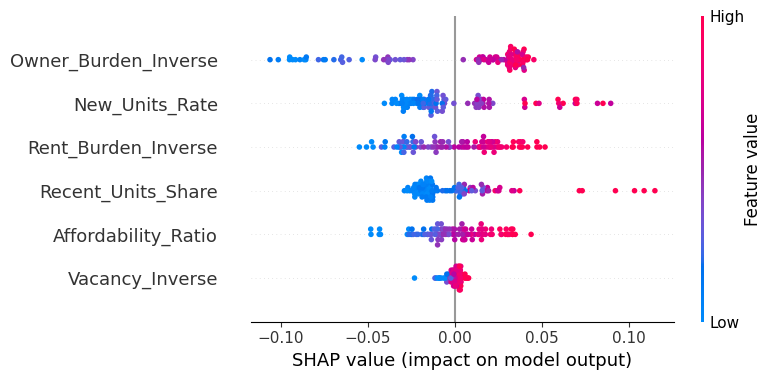

In [95]:
import shap
import xgboost as xgb
from sklearn.model_selection import train_test_split

# Feature matrix and target
X = normalized_features
y = housing_index_df['Housing_Market_Index']

# Train simple model for SHAP
model = xgb.XGBRegressor(n_estimators=100, max_depth=3, random_state=42)
model.fit(X, y)

# Create SHAP explainer
explainer = shap.Explainer(model, X)
shap_values = explainer(X)

# Plot summary of SHAP values
shap.summary_plot(shap_values, X, show=True)


# Job Market Index

In [96]:
import pandas as pd
import sqlite3
import re

# Define file paths for metro-level labor market data
file_paths = {
    "B23025": "job_data/B23025.xlsx",         # Unemployment rate
    "B23001": "job_data/B23001.xlsx",         # NILF share
    "B07011": "job_data/B07011.xlsx",         # Moved population share (migration proxy)
    "B08301": "job_data/B08301.xlsx",         # Work from home share
    "B24080": "job_data/B24080.xlsx",         # Government worker share
    "B24031": "job_data/B24031.xlsx",         # Retail/Hospitality worker share
    "PEPANNRES": "job_data/PEPANNRES.xlsx",   # Population
    "LAUS": "job_data/LAUS.xlsx"              # Official unemployment rate
}

# Helper to deduplicate columns after cleaning
def deduplicate_columns(columns):
    seen = {}
    new_cols = []
    for col in columns:
        if col not in seen:
            seen[col] = 1
            new_cols.append(col)
        else:
            seen[col] += 1
            new_cols.append(f"{col}_{seen[col] - 1}")
    return new_cols

# Load and clean each file
dfs = {}
for key, path in file_paths.items():
    df = pd.read_excel(path, sheet_name=0)

    # Clean whitespace and punctuation from column names
    df.columns = [re.sub(r"[\xa0\s]+", " ", col).strip().replace(":", "") for col in df.columns]
    df.columns = deduplicate_columns(df.columns)

    # Rename known conflicts in B23025
    if key == "B23025":
        df = df.rename(columns={
            "Employed": "Employed_Total",
            "Employed_1": "Employed_Alt",
            "Unemployed": "Unemployed_Total",
            "Unemployed_1": "Unemployed_Alt",
            "Civilian labor force": "Civilian_Labor_Force"
        })

    # Clean "Geography" column
    if "Geography" in df.columns:
        df["Geography"] = df["Geography"].str.strip()
        df["Geography"] = df["Geography"].str.replace(" Metro Area", "", regex=False)
        df["Geography"] = df["Geography"].str.replace(" MSA", "", regex=False)
        df["Geography"] = df["Geography"].str.replace("–", "-", regex=False)
        df["Geography"] = df["Geography"].str.replace("—", "-", regex=False)
        df["Geography"] = df["Geography"].str.replace(u"\xa0", " ", regex=False)
        df["Geography"] = df["Geography"].str.split(",|-").str[0].str.strip()

    dfs[key] = df

# Debug: verify columns for mobility table
print("B07011 columns:", dfs["B07011"].columns.tolist())

# Create in-memory SQLite DB
conn = sqlite3.connect(":memory:")

# Load DataFrames into SQLite
for name, df in dfs.items():
    df.to_sql(name, conn, index=False, if_exists='replace')

# SQL query: include only columns required for engineered features
sql_query = """
SELECT 
    B23025.Geography AS Metro_Area,

    -- 🧮 For Unemployment Rate:
    B23025.[Unemployed_Total],
    B23025.[Civilian_Labor_Force],

    -- 🧮 For NILF share:
    B23001.[Not in labor force],
    B23001.[Total] AS Population_16Plus,

    -- 🧮 For Migration Share:
    B07011.[Moved within same county],
    B07011.[Moved from different county within same state],
    B07011.[Moved from different state],
    B07011.[Moved from abroad],
    B07011.[Total],

    -- 🧮 For Remote Capable Share:
    B08301.[Worked from home],
    B08301.[Total] AS Commuting_Total,

    -- 🧮 For Public Sector Share:
    B24080.[Federal government workers],
    B24080.[State government workers],
    B24080.[Local government workers],

    B24080.[Total] AS ClassOfWorker_Total,

    -- 🧮 For Retail/Hospitality Share:
    B24031.[Retail trade],
    B24031.[Accommodation and food services],
    B24031.[Total] AS Industry_Total,

    -- 🧮 For Population normalization:
    PEPANNRES.Population,

    -- 🧮 For Official Unemployment Rate:
    LAUS.[UnemploymentRate] AS Official_Unemployment_Rate

FROM B23025
LEFT JOIN B23001 ON B23025.Geography = B23001.Geography
LEFT JOIN B07011 ON B23025.Geography = B07011.Geography
LEFT JOIN B08301 ON B23025.Geography = B08301.Geography
LEFT JOIN B24080 ON B23025.Geography = B24080.Geography
LEFT JOIN B24031 ON B23025.Geography = B24031.Geography
LEFT JOIN PEPANNRES ON B23025.Geography = PEPANNRES.Geography
LEFT JOIN LAUS ON B23025.Geography = LAUS.Geography
GROUP BY B23025.Geography
ORDER BY PEPANNRES.Population DESC
LIMIT 100
"""

# Load query result
job_base_df = pd.read_sql_query(sql_query, conn)

# Close DB
conn.close()

# Show final dataset
job_base_df



B07011 columns: ['Geography', 'Median income in the past 12 months --', 'Total', 'Same house 1 year ago', 'Moved within same county', 'Moved from different county within same state', 'Moved from different state', 'Moved from abroad']


,Metro_Area,Unemployed_Total,Civilian_Labor_Force,Not in labor force,Population_16Plus,Moved within same county,Moved from different county within same state,Moved from different state,Moved from abroad,Total,...,Commuting_Total,Federal government workers,State government workers,Local government workers,ClassOfWorker_Total,Retail trade,Accommodation and food services,Industry_Total,Population,Official_Unemployment_Rate
0,New York,541096,10369544,348868.0,15898993.0,47993.0,50881.0,52473.0,21900,46370.0,...,9618141.0,97840.0,152215.0,377148.0,9828448.0,34755,27205,57515,19052774,0.041
1,Los Angeles,375952,6872715,240043.0,10524502.0,41814.0,36811.0,48699.0,21375,40613.0,...,6340771.0,56149.0,84235.0,199864.0,6496763.0,34463,27011,49028,12828837,0.048
2,Chicago,246527,5038371,145672.0,7510444.0,43896.0,45085.0,39234.0,20805,44867.0,...,4708208.0,48887.0,43728.0,148172.0,4791844.0,32060,24581,52174,9461105,0.048
3,Dallas,173483,4411687,142873.0,6334567.0,40240.0,44179.0,45434.0,22546,43597.0,...,4175270.0,39815.0,39819.0,108238.0,4238204.0,32051,20975,50918,6366542,0.035
4,Philadelphia,148605,3335735,102426.0,5085287.0,40828.0,36520.0,39638.0,19524,44230.0,...,3132908.0,41956.0,43015.0,91328.0,3187130.0,31933,20070,54691,5965343,0.038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Santa Rosa,10473,262269,7332.0,403547.0,45643.0,47701.0,64152.0,20531,48527.0,...,244909.0,1384.0,2575.0,9687.0,251796.0,37085,27415,53741,483878,0.040
96,Lexington,10571,280079,8811.0,421433.0,22673.0,27156.0,27735.0,15625,38710.0,...,263401.0,3630.0,9306.0,6549.0,269508.0,29861,17213,44513,478930,0.033
97,Pensacola,11302,248572,7204.0,432684.0,34399.0,29379.0,30552.0,50073,38358.0,...,246301.0,7049.0,4710.0,6140.0,237270.0,30267,21840,42476,455139,0.037
98,Visalia,17836,216252,10883.0,355039.0,33815.0,30750.0,55359.0,7528,32020.0,...,193315.0,1402.0,5018.0,8782.0,198416.0,32225,21379,40321,442179,0.103


In [97]:
job_base_df.dropna()
job_base_df

,Metro_Area,Unemployed_Total,Civilian_Labor_Force,Not in labor force,Population_16Plus,Moved within same county,Moved from different county within same state,Moved from different state,Moved from abroad,Total,...,Commuting_Total,Federal government workers,State government workers,Local government workers,ClassOfWorker_Total,Retail trade,Accommodation and food services,Industry_Total,Population,Official_Unemployment_Rate
0,New York,541096,10369544,348868.0,15898993.0,47993.0,50881.0,52473.0,21900,46370.0,...,9618141.0,97840.0,152215.0,377148.0,9828448.0,34755,27205,57515,19052774,0.041
1,Los Angeles,375952,6872715,240043.0,10524502.0,41814.0,36811.0,48699.0,21375,40613.0,...,6340771.0,56149.0,84235.0,199864.0,6496763.0,34463,27011,49028,12828837,0.048
2,Chicago,246527,5038371,145672.0,7510444.0,43896.0,45085.0,39234.0,20805,44867.0,...,4708208.0,48887.0,43728.0,148172.0,4791844.0,32060,24581,52174,9461105,0.048
3,Dallas,173483,4411687,142873.0,6334567.0,40240.0,44179.0,45434.0,22546,43597.0,...,4175270.0,39815.0,39819.0,108238.0,4238204.0,32051,20975,50918,6366542,0.035
4,Philadelphia,148605,3335735,102426.0,5085287.0,40828.0,36520.0,39638.0,19524,44230.0,...,3132908.0,41956.0,43015.0,91328.0,3187130.0,31933,20070,54691,5965343,0.038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Santa Rosa,10473,262269,7332.0,403547.0,45643.0,47701.0,64152.0,20531,48527.0,...,244909.0,1384.0,2575.0,9687.0,251796.0,37085,27415,53741,483878,0.040
96,Lexington,10571,280079,8811.0,421433.0,22673.0,27156.0,27735.0,15625,38710.0,...,263401.0,3630.0,9306.0,6549.0,269508.0,29861,17213,44513,478930,0.033
97,Pensacola,11302,248572,7204.0,432684.0,34399.0,29379.0,30552.0,50073,38358.0,...,246301.0,7049.0,4710.0,6140.0,237270.0,30267,21840,42476,455139,0.037
98,Visalia,17836,216252,10883.0,355039.0,33815.0,30750.0,55359.0,7528,32020.0,...,193315.0,1402.0,5018.0,8782.0,198416.0,32225,21379,40321,442179,0.103


### Feature Engineering

| **Feature**                | **Formula / Source**                                                                      | **Description**                               |
| -------------------------- | ----------------------------------------------------------------------------------------- | --------------------------------------------- |
| `Unemployment_Rate`        | `Unemployed_Total / Civilian_Labor_Force` from B23025                                     | Standard unemployment                         |
| `NILF_Share`               | `Not in labor force / Population 16+` from B23001                                         | People not in labor force                     |
| `Moved_Share`              | `(Moved within county + different county + different state + abroad) / Total` from B07011 | Proxy for geographic fluidity                 |
| `Remote_Capable_Share`     | `Worked at home / Commuting_Total` from B08301                                            | Proxy for labor market resilience             |
| `Public_Sector_Share`      | `Government workers / ClassOfWorker_Total` from B24080                                    | Public sector is more stable (can freeze too) |
| `Retail_Hospitality_Share` | `(Retail trade + Accommodation and food services) / Industry_Total` from B24031           | High = more freeze-prone industries           |
| `Official_Unemployment`    | Directly from LAUS `[Unemployment Rate]`                                                  | Benchmark from BLS official estimate          |


In [98]:
# Convert all relevant columns to numeric (safe conversion, turn errors into NaN)
cols_to_convert = [
    'Unemployed_Total', 'Civilian_Labor_Force',
    'Not in labor force', 'Population_16Plus',
    'Moved within same county', 'Moved from different county within same state',
    'Moved from different state', 'Moved from abroad', 'Total',
    'Worked from home', 'Commuting_Total',
    'Federal government workers', 'State government workers', 'Local government workers',
    'ClassOfWorker_Total', 'Retail trade', 'Accommodation and food services',
    'Industry_Total', 'Official_Unemployment_Rate'
]

job_base_df[cols_to_convert] = job_base_df[cols_to_convert].apply(pd.to_numeric, errors='coerce')

job_base_df['Unemployment_Rate'] = job_base_df['Unemployed_Total'] / job_base_df['Civilian_Labor_Force']
job_base_df['NILF_Share'] = job_base_df['Not in labor force'] / job_base_df['Population_16Plus']
job_base_df['Moved_Share'] = (job_base_df['Moved within same county'] + job_base_df['Moved from different county within same state'] + job_base_df['Moved from different state'] + job_base_df['Moved from abroad'])/job_base_df['Total']
job_base_df['Remote_Capable_Share'] = job_base_df['Worked from home'] / job_base_df['Commuting_Total']
job_base_df['Public_Sector_Share'] = (job_base_df['Federal government workers'] + job_base_df['State government workers'] + job_base_df['Local government workers']) / job_base_df['ClassOfWorker_Total']
job_base_df['Retail_Hospitality_Share'] = (job_base_df['Retail trade'] + job_base_df['Accommodation and food services']) / job_base_df['Industry_Total'] 
job_base_df['Offical_Unemployment'] = job_base_df['Official_Unemployment_Rate']


In [99]:
from sklearn.preprocessing import MinMaxScaler

# Define features used in the index
frozen_features = {
    'Unemployment_Rate': job_base_df['Unemployment_Rate'],
    'NILF_Share': job_base_df['NILF_Share'],
    'Moved_Inverse': 1 - job_base_df['Moved_Share'],
    'Retail_Hospitality_Share': job_base_df['Retail_Hospitality_Share'],
    'Remote_Capable_Inverse': 1 - job_base_df['Remote_Capable_Share'],
    'Public_Sector_Share': job_base_df['Public_Sector_Share']
}

# Create DataFrame of these features
frozen_feature_df = pd.DataFrame(frozen_features)

# Apply Min-Max Normalization to scale everything between 0 and 1
scaler = MinMaxScaler()
normalized_frozen_features = pd.DataFrame(
    scaler.fit_transform(frozen_feature_df),
    columns=frozen_feature_df.columns,
    index=frozen_feature_df.index
)

# Weighted Composite Index Calculation
job_base_df['Frozen_Market_Index'] = (
    0.25 * normalized_frozen_features['Unemployment_Rate'] +
    0.20 * normalized_frozen_features['NILF_Share'] +
    0.15 * normalized_frozen_features['Moved_Inverse'] +
    0.15 * normalized_frozen_features['Retail_Hospitality_Share'] +
    0.15 * normalized_frozen_features['Remote_Capable_Inverse'] +
    0.10 * normalized_frozen_features['Public_Sector_Share']
)

# View result
job_base_df[['Metro_Area', 'Frozen_Market_Index']].sort_values(by='Frozen_Market_Index', ascending=False)



,Metro_Area,Frozen_Market_Index
57,Bakersfield,0.766426
98,Visalia,0.753414
50,Fresno,0.689164
94,Modesto,0.653501
69,Stockton,0.610178
...,...,...
23,Charlotte,0.268793
15,Minneapolis,0.268790
92,Portland,0.268362
44,Raleigh,0.236793


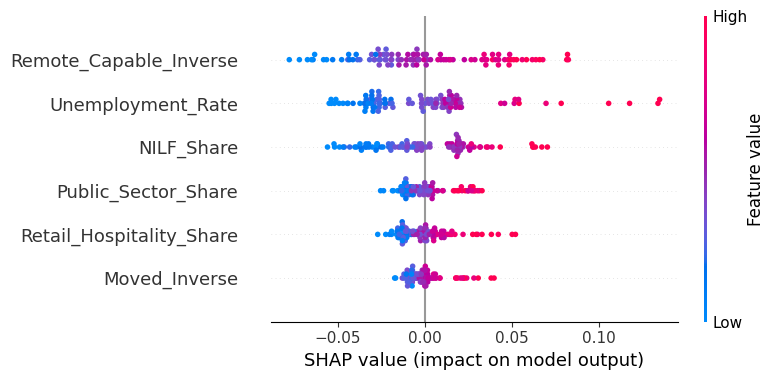

In [101]:
# Drop rows with NaNs in either features or target
df_shap = normalized_frozen_features.copy()
df_shap['Frozen_Market_Index'] = job_base_df['Frozen_Market_Index']
df_shap = df_shap.dropna()

X_shap = df_shap.drop(columns='Frozen_Market_Index')
y_shap = df_shap['Frozen_Market_Index']

# Fit model
model = xgb.XGBRegressor(n_estimators=100, max_depth=3, random_state=42)
model.fit(X_shap, y_shap)

# SHAP explanation
explainer = shap.Explainer(model, X_shap)
shap_values = explainer(X_shap)

# Plot
shap.summary_plot(shap_values, X_shap, show=True)
